## The symmetric 4-city problem

solving the bottleneck travelling salesman problem using phase estimation.

### testing contraint:

 - 6 qubits for phase estimation.
 - 8 qubits initialized to the eigenvalue of the of the matrix $U$.
 - There are 3 hamilonian cycles, so we need eigenvalue and estimation qubits for each.
 - To solve the constraint problem we need a new operator $U$ satifying a max edge weight.

<div>
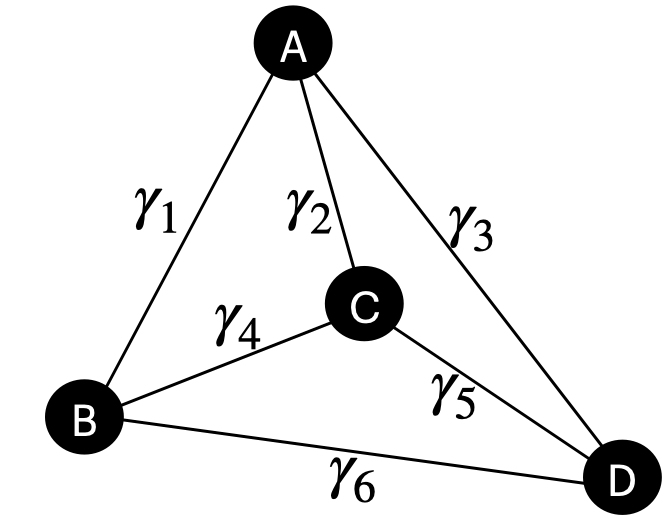
</div>

### we can assign arbitrary weights

$$\Large 1: A\xrightarrow{\gamma_1}B \xrightarrow{\gamma_4}C \xrightarrow{\gamma_5}D\xrightarrow{\gamma_3}A: 4 + 4 + \mathbf{5} + 4 = 17$$

$$\Large 2: A\xrightarrow{\gamma_1}B \xrightarrow{\gamma_6}D \xrightarrow{\gamma_5}C\xrightarrow{\gamma_2}A: 4 + \mathbf{6} + 5 + 2 = 17$$

$$\Large 3: A\xrightarrow{\gamma_2}C \xrightarrow{\gamma_4}B \xrightarrow{\gamma_6}D\xrightarrow{\gamma_3}A: 2 + 4 + \mathbf{6} + 4 = 16$$

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import math

gamma_1 = 4 # a <-> b
gamma_2 = 2 # a <-> c
gamma_3 = 4 # a <-> d
gamma_4 = 4 # b <-> c
gamma_5 = 5 # c <-> d
gamma_6 = 6 # b <-> d

weights = []

for i in range(1, 7):
    variable_name = "gamma_" + str(i)
    # Assuming you have variables like number_1, number_2, etc.
    current_number = locals()[variable_name]
    weights.append(current_number)

weights = np.array(weights)
print(weights)


[4 2 4 4 5 6]


we need to normalize the weights, $w$, so we only have values in $(0, 2\pi)$. We can do this by:

$$\Large w = \frac{w}{\mathrm{max}(w) + \epsilon} \times 2\pi$$

The addition of $\epsilon$ is included to avoid a max normalized weight of $2\pi$

**edit: normalizing by max does not work, we need to normalize by largest hamiltonian cycle, then multiply by $2\pi$**

we can just use the values we have above for now, but might be worth considering what strategy works best.
 - simplest solution would be to normalize based on the sum of all edge weights
 
 $$\Large w = \frac{w}{\mathrm{sum}(w)} \times 2\pi$$
 
 
 **edit2: multiplying it by $2\pi$ made it hard to verify where the solutions are, going to attempt again but multiply it by $\pi$**

we can just use the values we have above for now, but might be worth considering what strategy works best.
 - simplest solution would be to normalize based on the sum of all edge weights
 
 $$\Large w = \frac{w}{\mathrm{sum}(w)} \times \pi$$


In [4]:
eps = 1
#weights = weights / (max(weights) + eps) * 2 * np.pi
weights = weights / np.sum(weights) * np.pi

print('normalized weights: {}'.format(weights))

## solutions
print('solution 1: {}'.format(weights[0] + weights[3] + weights[4] + weights[2]))
print('solution 2: {}'.format(weights[0] + weights[5] + weights[4] + weights[1]))
print('solution 3: {}'.format(weights[1] + weights[3] + weights[5] + weights[2]))

print('solutions after max weight removed')
print('solution 1: {}'.format(weights[0] + weights[3] + weights[4] + weights[2]))
print('solution 2: {}'.format(weights[0]  + weights[4] + weights[1]))
print('solution 3: {}'.format(weights[1] + weights[3] + weights[2]))

normalized weights: [0.50265482 0.25132741 0.50265482 0.50265482 0.62831853 0.75398224]
solution 1: 2.1362830044410597
solution 2: 2.1362830044410592
solution 3: 2.0106192982974678
solutions after max weight removed
solution 1: 2.1362830044410597
solution 2: 1.3823007675795091
solution 3: 1.2566370614359172


To construct $U$, we need to compute the tensor product of diagonal matrices $U_j$, where $ 1 \leq j \leq N$. $N$ denotes the number of cities in total.

$$\Large\left[U_j \right]_{kk} = \frac{1}{\sqrt{N}}e^{i\gamma_{jk}}$$


$$\Large U = \bigotimes_j^N U_j$$


for our contstraint test, we simply need a tensor product of 4 matrices:

$$\Large U = U_1 \otimes U_2 \otimes U_3 \otimes U_4$$

lets have a closer look at the matrix $U_1$
$$ \Large
\begin{bmatrix}
  1 & 0 & 0 & 0 \\
  0 & e^{i\gamma_{12}} & 0 & 0 \\
  0 & 0 & e^{i\gamma_{13}} & 0 \\
  0 & 0 & 0 & e^{i\gamma_{14}} \\
\end{bmatrix}
$$

constructing the large matrix U is straight forward. I am a little confused on how to construct a controlled-U operation such that we have the appropriate phase kickback. The 2018 paper does a decomposition, and claims that a $CU$ matrix can simply be achieved by the tensor product of the smaller $CU_J$ matrices. Need to confirm how this works.

A control gate can simply be constructed:

$$ \Large
\begin{bmatrix}
  \mathbb{1} & 0 \\
  0 & U \\
\end{bmatrix}
$$ 


#### January 16th clarification:

to construct a control gate, we need an equal amount of diagonal elements for the identity matrix above as we have in the diagonal of U, implying we double the size of U and store 1s in the first half of the diagonal 



#### January 31st clarification:

qiskit orders qubits backwards. This control gate needs to be reflected over the diagonal:

$$ \Large
\begin{bmatrix}
  U & 0 \\
  0 & \mathbb{1} \\
\end{bmatrix}
$$ 

In [3]:
# # https://github.com/qiskit-community/qiskit-textbook/blob/main/content/ch-algorithms/quantum-phase-estimation.ipynb
# # https://www.youtube.com/watch?v=zFgyMGklANM (how to create a custom gate)  

# # importing Qiskit
# from qiskit import IBMQ, Aer, transpile, assemble
# from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
# from qiskit.circuit.library import QFT

# # for creating custom gates
# from qiskit import quantum_info as qi

# # import basic plot tools
# from qiskit.visualization import plot_histogram

In [9]:
# qiskit tools to establish circuit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# importing QFT
from qiskit.circuit.library import QFT

# for creating custom gates
from qiskit import quantum_info as qi

# import basic plot tools
from qiskit.visualization import plot_histogram

In [7]:
n = 3 # estimation qubits
m = 8 # eigenvalue qubits

qr = QuantumRegister(n, name = 'phase')
qr2 = QuantumRegister(m, name = 'eigenstate')
cr = ClassicalRegister(n, 'output')

qrp = QuantumRegister(n, name = 'phase two')
qr2p = QuantumRegister(m, name = 'eigstate two')
crp = ClassicalRegister(n, 'output two')

qc = QuantumCircuit(qr,qr2,cr,qrp,qr2p,crp)


# Apply H-Gates to counting qubits:
for qubit in range(2*n):
    if qubit < n:
        qc.h(qubit)
    else:
        qc.h(qubit + m)

# Prepare our eigenstate |psi>: state 198
eig = '11000110'

eigstatelist = ['11000110', '01101100', '10001101',
                '01110010', '11100001', '10110100']

for ind, val in enumerate(eig):
    if(int(val)):
        qc.x(ind + n)
        qc.x(ind + 2*n + m)
        
qc.draw()

┌───┐
       phase_0: ┤ H ├
                ├───┤
       phase_1: ┤ H ├
                ├───┤
       phase_2: ┤ H ├
                ├───┤
  eigenstate_0: ┤ X ├
                ├───┤
  eigenstate_1: ┤ X ├
                └───┘
  eigenstate_2: ─────
                     
  eigenstate_3: ─────
                     
  eigenstate_4: ─────
                ┌───┐
  eigenstate_5: ┤ X ├
                ├───┤
  eigenstate_6: ┤ X ├
                └───┘
  eigenstate_7: ─────
                ┌───┐
   phase two_0: ┤ H ├
                ├───┤
   phase two_1: ┤ H ├
                ├───┤
   phase two_2: ┤ H ├
                ├───┤
eigstate two_0: ┤ X ├
                ├───┤
eigstate two_1: ┤ X ├
                └───┘
eigstate two_2: ─────
                     
eigstate two_3: ─────
                     
eigstate two_4: ─────
                ┌───┐
eigstate two_5: ┤ X ├
                ├───┤
eigstate two_6: ┤ X ├
                └───┘
eigstate two_7: ─────
                     
      output: 3/═════
                     
  output two: 3/═════

## creating CU matrix

In [13]:
### need the four values for each sub distance matrix:

U111 = 1
U122 = np.exp(1j * weights[0])
U133 = np.exp(1j * weights[1])
U144 = np.exp(1j * weights[2])
U1 = np.diag([U111, U122, U133, U144])

U211 = np.exp(1j * weights[0])
U222 = 1
U233 = np.exp(1j * weights[3])
U244 = np.exp(1j * weights[4])
U2 = np.diag([U211, U222, U233, U244])

U311 = np.exp(1j * weights[1])
U322 = np.exp(1j * weights[3])
U333 = 1
U344 = np.exp(1j * weights[4])
U3 = np.diag([U311, U322, U333, U344])

U411 = np.exp(1j * weights[2])
U422 = np.exp(1j * weights[5])
U433 = np.exp(1j * weights[4])
U444 = 1
U4 = np.diag([U411, U422, U433, U444])

## tensor product all of them
## Add ones to the diagonal (first half)

U = np.kron(np.kron(np.kron(U1,U2),U3),U4)
print(np.all(np.diag(U) != 0))# confirming only the diagonal is being used.

##CUdiag = np.append(np.ones(2**m), np.diag(U))
CUdiag = np.append(np.diag(U), np.ones(2**m))


CU = qi.Operator(np.diag(CUdiag))
print(np.shape(CU))  ### needs to work on m + 1 qubits (2^(m+1) x 2^(m+1) matrix)


True
(512, 512)


## Confirming where the solutions are:



In [16]:
U_angles = np.around(np.diag(np.angle(U)), 4)

# solution 1: 2.1362830044410597
# solution 2: 2.1362830044410592
# solution 3: 2.0106192982974678

# U_angles = U_angles[U_angles > 2] ## range here is -pi to pi. Changing it to 0 to 2pi
# U_angles = U_angles[U_angles < 2.2]
# U_angles
print(np.where(U_angles==2.0106)) ### solution 3
print(np.where(U_angles == 2.1363)) ## solution 1 & 2

(array([ 61,  65,  68,  97, 100, 114, 133, 142, 165, 174, 182, 188, 193,
       196, 225, 228, 242]),)
(array([ 70,  76, 102, 108, 113, 116, 141, 173, 181, 190, 198, 204, 230,
       236, 241, 244]),)


In [15]:
# #manual multiplication for confirmation
# eigstate = np.zeros(256)
# eigstate[198] = 1   # where the solution is |111000110>
# eigstate = eigstate.reshape(-1,1) # changing to a column vector
# product = np.matmul(U,eigstate)
# print(np.where(np.angle(product) != 0)) ## confirming only same index has a nonzero value
# print(np.angle(product)[198])


# ### how would this work with CU

# CU_check = np.append(np.ones(2**m), np.diag(U))
# CU_check = np.diag(CU_check)

# eigstate = np.zeros(512)
# eigstate[454] = 1   # where the solution is |1>|111000110>
# eigstate = eigstate.reshape(-1,1) # changing to a column vector
# product = np.matmul(CU_check,eigstate)
# print(np.where(np.angle(product) != 0)) ## confirming only same index has a nonzero value
# print(np.angle(product)[454])

## Creating CU Prime matrix (removing max edge weight)

In [8]:
### need the four values for each sub distance matrix:

max_index = np.where(weights == np.max(weights))[0][0] ## largest weight in weights index
weights[max_index] = 0                                 ## setting the largest weight to zero

U111 = 1
U122 = np.exp(1j * weights[0])
U133 = np.exp(1j * weights[1])
U144 = np.exp(1j * weights[2])
U1 = np.diag([U111, U122, U133, U144])

U211 = np.exp(1j * weights[0])
U222 = 1
U233 = np.exp(1j * weights[3])
U244 = np.exp(1j * weights[4])
U2 = np.diag([U211, U222, U233, U244])

U311 = np.exp(1j * weights[1])
U322 = np.exp(1j * weights[3])
U333 = 1
U344 = np.exp(1j * weights[4])
U3 = np.diag([U311, U322, U333, U344])

U411 = np.exp(1j * weights[2])
U422 = np.exp(1j * weights[5])
U433 = np.exp(1j * weights[4])
U444 = 1
U4 = np.diag([U411, U422, U433, U444])

## tensor product all of them
## Add ones to the diagonal (first half)

Up = np.kron(np.kron(np.kron(U1,U2),U3),U4)
print(U != 0)# confirming only the diagonal is being used.

#CUdiag = np.append(np.ones(2**m), np.diag(Up))
CUdiag = np.append(np.diag(Up), np.ones(2**m))

CUP = qi.Operator(np.diag(CUdiag))
print(np.shape(CUP))  ### needs to work on m + 1 qubits (2^(m+1) x 2^(m+1) matrix)
#CUP_check = UnitaryGate(np.diag(CUdiag), label='cupcheck')

[[ True False False ... False False False]
 [False  True False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True False]
 [False False False ... False False  True]]
(512, 512)


In [9]:
Up_angles = np.around(np.diag(np.angle(U)), 4)
#solutions = [4.27,4.27,4.02]
#U_angles = U_angles[U_angles > 2] ## range here is -pi to pi. Changing it to 0 to 2pi
#U_angles = U_angles[U_angles < 4.5]
np.where(Up_angles==1.9448)



(array([], dtype=int64),)

In [11]:
eig_qubits = np.arange(0,m) + n

repetitions = 1
for counting_qubit in range(n):
    applied_qubits = np.append([counting_qubit], [eig_qubits])
    for i in range(repetitions):
        qpe.unitary(CU, list(applied_qubits), label = "CU"); # This is CU
    repetitions *= 2
    
draw=1
if draw:
    qpe.draw()



In [12]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

        
# def qft_dagger(qc, n, k):
#     """n-qubit QFTdagger the first n qubits in circ
#         rewriting to account for a bit shift
#     """
#     # Don't forget the Swaps!
#     for qubit in range(n//2):
#         qc.swap(k + qubit, k + n-qubit-1)
#     for j in range(n):
#         for m in range(j):
#             qc.cp(-math.pi/float(2**(j-m)), m, j)
#         qc.h(j)
        

qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, n)
# Measure
qpe.barrier()
for i in range(n):
    qpe.measure(i,i) 
    
if draw:
    qpe.draw()

In [13]:
if draw:
    qpe.draw(output = 'mpl')

/Users/raveel/miniconda3/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


In [14]:
#qpe.draw(output = 'latex') did not work


In [21]:
n = 3 # estimation qubits
m = 8 # eigenvalue qubits

qr = QuantumRegister(n, name = 'phase')
qr2 = QuantumRegister(m, name = 'eigenstate')
cr = ClassicalRegister(n, 'output')

qrp = QuantumRegister(n, name = 'phase two')
qr2p = QuantumRegister(m, name = 'eigstate two')
crp = ClassicalRegister(n, 'output two')

qc = QuantumCircuit(qr,qr2,cr,qrp,qr2p,crp)


# Apply H-Gates to counting qubits:
for qubit in range(2*n):
    if qubit < n:
        qc.h(qubit)
    else:
        qc.h(qubit + m)

# Prepare our eigenstate |psi>: state 198
eig = '11000110'

eigstatelist = ['11000110', '01101100', '10001101',
                '01110010', '11100001', '10110100']

for ind, val in enumerate(eig):
    if(int(val)):
        qc.x(ind + n)
        qc.x(ind + 2*n + m)


qc.draw()

┌───┐
       phase_0: ┤ H ├
                ├───┤
       phase_1: ┤ H ├
                ├───┤
       phase_2: ┤ H ├
                ├───┤
  eigenstate_0: ┤ X ├
                ├───┤
  eigenstate_1: ┤ X ├
                └───┘
  eigenstate_2: ─────
                     
  eigenstate_3: ─────
                     
  eigenstate_4: ─────
                ┌───┐
  eigenstate_5: ┤ X ├
                ├───┤
  eigenstate_6: ┤ X ├
                └───┘
  eigenstate_7: ─────
                ┌───┐
   phase two_0: ┤ H ├
                ├───┤
   phase two_1: ┤ H ├
                ├───┤
   phase two_2: ┤ H ├
                ├───┤
eigstate two_0: ┤ X ├
                ├───┤
eigstate two_1: ┤ X ├
                └───┘
eigstate two_2: ─────
                     
eigstate two_3: ─────
                     
eigstate two_4: ─────
                ┌───┐
eigstate two_5: ┤ X ├
                ├───┤
eigstate two_6: ┤ X ├
                └───┘
eigstate two_7: ─────
                     
      output: 3/═════
                     
  output two: 3/═════

In [22]:
eig_qubits = np.arange(0,m) + n
eig_qubits2 = np.arange(0,m) + 2*n + m

repetitions = 1
for counting_qubit in range(n):
    applied_qubits = np.append([counting_qubit], [eig_qubits])
    applied_qubits2 = np.append([counting_qubit + m + n], [eig_qubits2])
    for i in range(repetitions):
        qc.unitary(CU, list(applied_qubits), label = "CU"); # This is CU
        qc.unitary(CUP, list(applied_qubits2), label = "CU'");
    repetitions *= 2
    
qc.append(QFT(num_qubits = n, inverse = True), qr)
qc.append(QFT(num_qubits = n, inverse = True), qrp)

qc.measure(qr,cr)
qc.measure(qrp,crp)

qc.draw()

┌───┐┌─────┐                                                 »
       phase_0: ┤ H ├┤0    ├─────────────────────────────────────────────────»
                ├───┤│     │ ┌─────┐ ┌─────┐                                 »
       phase_1: ┤ H ├┤     ├─┤0    ├─┤0    ├─────────────────────────────────»
                ├───┤│     │ │     │ │     │ ┌─────┐ ┌─────┐ ┌─────┐ ┌─────┐ »
       phase_2: ┤ H ├┤     ├─┤     ├─┤     ├─┤0    ├─┤0    ├─┤0    ├─┤0    ├─»
                ├───┤│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_0: ┤ X ├┤1    ├─┤1    ├─┤1    ├─┤1    ├─┤1    ├─┤1    ├─┤1    ├─»
                ├───┤│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_1: ┤ X ├┤2    ├─┤2    ├─┤2    ├─┤2    ├─┤2    ├─┤2    ├─┤2    ├─»
                └───┘│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_2: ─────┤3 CU ├─┤3    ├─┤3    ├─┤3    ├─┤3    ├─┤3    ├─┤3    ├─»
                     │     │ │  CU │ │  CU │ │     │ │     │ │     │ │     │ »
  eigenstate_3: ─────┤4    ├─┤4    ├─┤4    ├─┤4 CU ├─┤4 CU ├─┤4 CU ├─┤4 CU ├─»
                     │     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_4: ─────┤5    ├─┤5    ├─┤5    ├─┤5    ├─┤5    ├─┤5    ├─┤5    ├─»
                ┌───┐│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_5: ┤ X ├┤6    ├─┤6    ├─┤6    ├─┤6    ├─┤6    ├─┤6    ├─┤6    ├─»
                ├───┤│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_6: ┤ X ├┤7    ├─┤7    ├─┤7    ├─┤7    ├─┤7    ├─┤7    ├─┤7    ├─»
                └───┘│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_7: ─────┤8    ├─┤8    ├─┤8    ├─┤8    ├─┤8    ├─┤8    ├─┤8    ├─»
                ┌───┐├─────┴┐└─────┘ └─────┘ └─────┘ └─────┘ └─────┘ └─────┘ »
   phase two_0: ┤ H ├┤0     ├────────────────────────────────────────────────»
                ├───┤│      │┌──────┐┌──────┐                                »
   phase two_1: ┤ H ├┤      ├┤0     ├┤0     ├────────────────────────────────»
                ├───┤│      ││      ││      │┌──────┐┌──────┐┌──────┐┌──────┐»
   phase two_2: ┤ H ├┤      ├┤      ├┤      ├┤0     ├┤0     ├┤0     ├┤0     ├»
                ├───┤│      ││      ││      ││      ││      ││      ││      │»
eigstate two_0: ┤ X ├┤1     ├┤1     ├┤1     ├┤1     ├┤1     ├┤1     ├┤1     ├»
                ├───┤│      ││      ││      ││      ││      ││      ││      │»
eigstate two_1: ┤ X ├┤2     ├┤2     ├┤2     ├┤2     ├┤2     ├┤2     ├┤2     ├»
                └───┘│      ││      ││      ││      ││      ││      ││      │»
eigstate two_2: ─────┤3 CU' ├┤3     ├┤3     ├┤3     ├┤3     ├┤3     ├┤3     ├»
                     │      ││  CU' ││  CU' ││      ││      ││      ││      │»
eigstate two_3: ─────┤4     ├┤4     ├┤4     ├┤4 CU' ├┤4 CU' ├┤4 CU' ├┤4 CU' ├»
                     │      ││      ││      ││      ││      ││      ││      │»
eigstate two_4: ─────┤5     ├┤5     ├┤5     ├┤5     ├┤5     ├┤5     ├┤5     ├»
                ┌───┐│      ││      ││      ││      ││      ││      ││      │»
eigstate two_5: ┤ X ├┤6     ├┤6     ├┤6     ├┤6     ├┤6     ├┤6     ├┤6     ├»
                ├───┤│      ││      ││      ││      ││      ││      ││      │»
eigstate two_6: ┤ X ├┤7     ├┤7     ├┤7     ├┤7     ├┤7     ├┤7     ├┤7     ├»
                └───┘│      ││      ││      ││      ││      ││      ││      │»
eigstate two_7: ─────┤8     ├┤8     ├┤8     ├┤8     ├┤8     ├┤8     ├┤8     ├»
                     └──────┘└──────┘└──────┘└──────┘└──────┘└──────┘└──────┘»
      output: 3/═════════════════════════════════════════════════════════════»
                                                                             »
  output two: 3/═════════════════════════════════════════════════════════════»
                                                                             »
«                ┌───────┐┌─┐               
«       phase_0: ┤0      ├┤M├───────────────
«                │       │└╥┘┌─┐            
«       ph

In [16]:
# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

In [17]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator')]

In [18]:
simulator = Aer.get_backend('aer_simulator')

In [23]:
qc = transpile(qc, simulator)  #### Doesnt like the inverse Quantum Fourier transform without decomposition
qc.draw()

┌───┐┌─────┐                                                 »
       phase_0: ┤ H ├┤0    ├─────────────────────────────────────────────────»
                ├───┤│     │ ┌─────┐ ┌─────┐                                 »
       phase_1: ┤ H ├┤     ├─┤0    ├─┤0    ├─────────────────────────────────»
                ├───┤│     │ │     │ │     │ ┌─────┐ ┌─────┐ ┌─────┐ ┌─────┐ »
       phase_2: ┤ H ├┤     ├─┤     ├─┤     ├─┤0    ├─┤0    ├─┤0    ├─┤0    ├─»
                ├───┤│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_0: ┤ X ├┤1    ├─┤1    ├─┤1    ├─┤1    ├─┤1    ├─┤1    ├─┤1    ├─»
                ├───┤│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_1: ┤ X ├┤2    ├─┤2    ├─┤2    ├─┤2    ├─┤2    ├─┤2    ├─┤2    ├─»
                └───┘│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_2: ─────┤3 CU ├─┤3    ├─┤3    ├─┤3    ├─┤3    ├─┤3    ├─┤3    ├─»
                     │     │ │  CU │ │  CU │ │     │ │     │ │     │ │     │ »
  eigenstate_3: ─────┤4    ├─┤4    ├─┤4    ├─┤4 CU ├─┤4 CU ├─┤4 CU ├─┤4 CU ├─»
                     │     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_4: ─────┤5    ├─┤5    ├─┤5    ├─┤5    ├─┤5    ├─┤5    ├─┤5    ├─»
                ┌───┐│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_5: ┤ X ├┤6    ├─┤6    ├─┤6    ├─┤6    ├─┤6    ├─┤6    ├─┤6    ├─»
                ├───┤│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_6: ┤ X ├┤7    ├─┤7    ├─┤7    ├─┤7    ├─┤7    ├─┤7    ├─┤7    ├─»
                └───┘│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_7: ─────┤8    ├─┤8    ├─┤8    ├─┤8    ├─┤8    ├─┤8    ├─┤8    ├─»
                ┌───┐├─────┴┐└─────┘ └─────┘ └─────┘ └─────┘ └─────┘ └─────┘ »
   phase two_0: ┤ H ├┤0     ├────────────────────────────────────────────────»
                ├───┤│      │┌──────┐┌──────┐                                »
   phase two_1: ┤ H ├┤      ├┤0     ├┤0     ├────────────────────────────────»
                ├───┤│      ││      ││      │┌──────┐┌──────┐┌──────┐┌──────┐»
   phase two_2: ┤ H ├┤      ├┤      ├┤      ├┤0     ├┤0     ├┤0     ├┤0     ├»
                ├───┤│      ││      ││      ││      ││      ││      ││      │»
eigstate two_0: ┤ X ├┤1     ├┤1     ├┤1     ├┤1     ├┤1     ├┤1     ├┤1     ├»
                ├───┤│      ││      ││      ││      ││      ││      ││      │»
eigstate two_1: ┤ X ├┤2     ├┤2     ├┤2     ├┤2     ├┤2     ├┤2     ├┤2     ├»
                └───┘│      ││      ││      ││      ││      ││      ││      │»
eigstate two_2: ─────┤3 CU' ├┤3     ├┤3     ├┤3     ├┤3     ├┤3     ├┤3     ├»
                     │      ││  CU' ││  CU' ││      ││      ││      ││      │»
eigstate two_3: ─────┤4     ├┤4     ├┤4     ├┤4 CU' ├┤4 CU' ├┤4 CU' ├┤4 CU' ├»
                     │      ││      ││      ││      ││      ││      ││      │»
eigstate two_4: ─────┤5     ├┤5     ├┤5     ├┤5     ├┤5     ├┤5     ├┤5     ├»
                ┌───┐│      ││      ││      ││      ││      ││      ││      │»
eigstate two_5: ┤ X ├┤6     ├┤6     ├┤6     ├┤6     ├┤6     ├┤6     ├┤6     ├»
                ├───┤│      ││      ││      ││      ││      ││      ││      │»
eigstate two_6: ┤ X ├┤7     ├┤7     ├┤7     ├┤7     ├┤7     ├┤7     ├┤7     ├»
                └───┘│      ││      ││      ││      ││      ││      ││      │»
eigstate two_7: ─────┤8     ├┤8     ├┤8     ├┤8     ├┤8     ├┤8     ├┤8     ├»
                     └──────┘└──────┘└──────┘└──────┘└──────┘└──────┘└──────┘»
      output: 3/═════════════════════════════════════════════════════════════»
                                                                             »
  output two: 3/═════════════════════════════════════════════════════════════»
                                                                             »
«                   ┌───┐                                   ┌─┐                »
«       phase_0: ─X─┤ H ├─■──────────────■──────────────────┤M├─

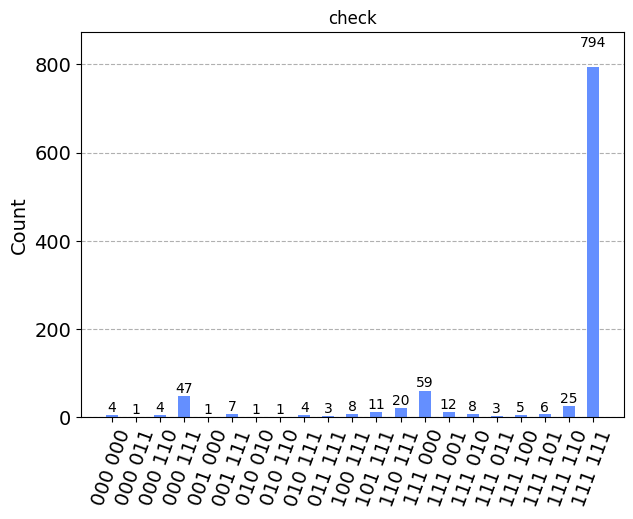

In [26]:
# Run and get counts
result = simulator.run(qc).result()
counts = result.get_counts(qc)
plot_histogram(counts, title='check')

## attempt 2

In [23]:
## https://www.youtube.com/watch?v=455pmYaZXKw&t=614s


from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.circuit.library import PhaseEstimation, RZGate
import numpy as np

In [24]:
evr = QuantumRegister(4,'eval')
qr = QuantumRegister(1, 'q')
cr = ClassicalRegister(4, 'c')

pe_circ = QuantumCircuit(evr, qr, cr)
pe_circ.x(qr)

#### estimating 0.42 #######
pe_circ.append(PhaseEstimation(4, RZGate(2*np.pi*2*0.42)), range(5))
pe_circ.draw()

┌──────┐
eval_0: ─────┤0     ├
             │      │
eval_1: ─────┤1     ├
             │      │
eval_2: ─────┤2 QPE ├
             │      │
eval_3: ─────┤3     ├
        ┌───┐│      │
     q: ┤ X ├┤4     ├
        └───┘└──────┘
   c: 4/═════════════

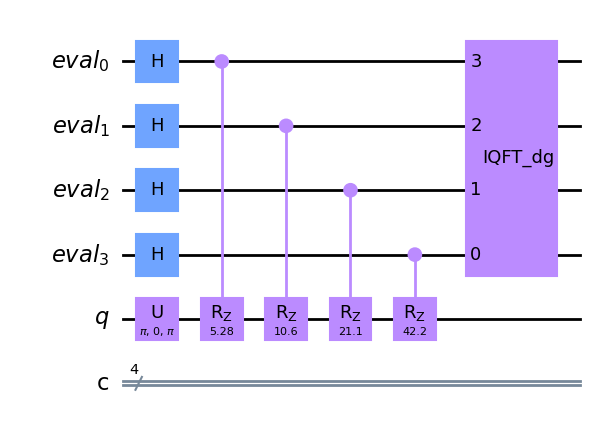

In [25]:
pe_circ.decompose(reps = 2).draw('mpl')

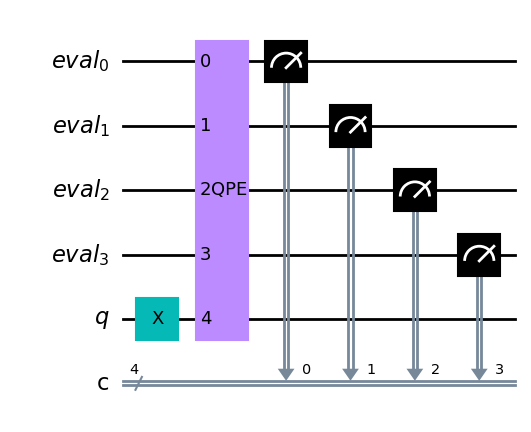

In [26]:
pe_circ.measure(evr, cr)
pe_circ.draw('mpl')

In [27]:
from qiskit.primitives import Sampler

sampler = Sampler()
results = sampler.run(pe_circ).result()

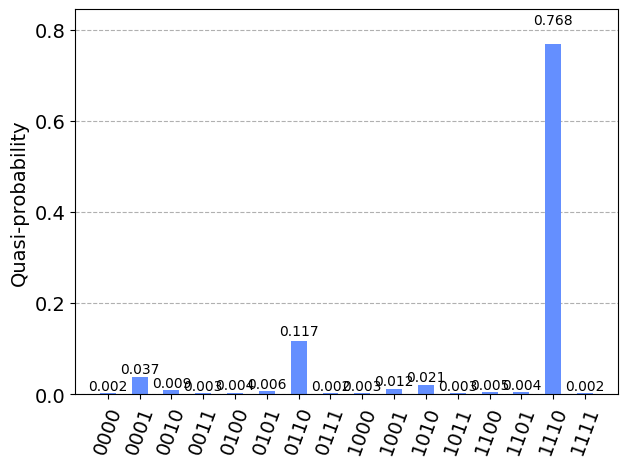

In [28]:
from qiskit.visualization import plot_histogram
 
plot_histogram(results.quasi_dists[0].binary_probabilities())

In [29]:
int("".join(reversed('1110')),2)/2**4

0.4375

In [30]:
int("".join(reversed('0110')),2)/2**4

0.375

In [31]:
### Initialize the circuit

n = 4 # for phase estimation
m = 8 # for eigenstate

qr = QuantumRegister(n, name = 'phase')
qr2 = QuantumRegister(m, name = 'eigenstate')
cr = ClassicalRegister(n, 'output')

qrp = QuantumRegister(n, name = 'phase two')
qr2p = QuantumRegister(m, name = 'eigstate two')
crp = ClassicalRegister(n, 'output two')

qc = QuantumCircuit(qr,qr2,cr,qrp,qr2p,crp)


# Apply H-Gates to counting qubits:
for qubit in range(2*n):
    if qubit < n:
        qc.h(qubit)
    else:
        qc.h(qubit + m)

# Prepare our eigenstate |psi>: state 198
eig = '11000110'

eigstatelist = ['11000110', '01101100', '10001101',
                '01110010', '11100001', '10110100']

for ind, val in enumerate(eig):
    if(int(val)):
        qc.x(ind + n)
        qc.x(ind + 2*n + m)

qc.draw()

┌───┐
       phase_0: ┤ H ├
                ├───┤
       phase_1: ┤ H ├
                ├───┤
       phase_2: ┤ H ├
                ├───┤
       phase_3: ┤ H ├
                ├───┤
  eigenstate_0: ┤ X ├
                ├───┤
  eigenstate_1: ┤ X ├
                └───┘
  eigenstate_2: ─────
                     
  eigenstate_3: ─────
                     
  eigenstate_4: ─────
                ┌───┐
  eigenstate_5: ┤ X ├
                ├───┤
  eigenstate_6: ┤ X ├
                └───┘
  eigenstate_7: ─────
                ┌───┐
   phase two_0: ┤ H ├
                ├───┤
   phase two_1: ┤ H ├
                ├───┤
   phase two_2: ┤ H ├
                ├───┤
   phase two_3: ┤ H ├
                ├───┤
eigstate two_0: ┤ X ├
                ├───┤
eigstate two_1: ┤ X ├
                └───┘
eigstate two_2: ─────
                     
eigstate two_3: ─────
                     
eigstate two_4: ─────
                ┌───┐
eigstate two_5: ┤ X ├
                ├───┤
eigstate two_6: ┤ X ├
                └───┘
eigstate two_7: ─────
                     
      output: 4/═════
                     
  output two: 4/═════

In [42]:
U = qi.Operator(U)

qc.append(PhaseEstimation(n, U), range(n + m))

AttributeError: 'Operator' object has no attribute 'control'

In [43]:
U

Operator([[ 0.30901699+0.95105652j,  0.        +0.j        ,
            0.        +0.j        , ...,  0.        +0.j        ,
            0.        +0.j        ,  0.        +0.j        ],
          [ 0.        +0.j        ,  0.06279052+0.99802673j,
            0.        +0.j        , ...,  0.        +0.j        ,
            0.        +0.j        ,  0.        +0.j        ],
          [ 0.        +0.j        ,  0.        +0.j        ,
            0.18738131+0.98228725j, ...,  0.        +0.j        ,
            0.        +0.j        ,  0.        +0.j        ],
          ...,
          [ 0.        +0.j        ,  0.        +0.j        ,
            0.        +0.j        , ..., -0.80901699+0.58778525j,
           -0.        +0.j        , -0.        +0.j        ],
          [ 0.        +0.j        ,  0.        +0.j        ,
            0.        +0.j        , ..., -0.        +0.j        ,
           -0.72896863+0.68454711j, -0.        +0.j        ],
          [ 0.        +0.j        ,  0. 

In [49]:
RZGate(2*np.pi*2*0.42).

Instruction(name='rz', num_qubits=1, num_clbits=0, params=[5.277875658030852])